In [1]:
import pandas as pd

from matplotlib import pyplot as plt
from pymgrid import Microgrid
from pymgrid.envs import DiscreteMicrogridEnv
from pymgrid.algos import RuleBasedControl
import gym

In [2]:
import numpy as np
import yaml

from pymgrid.microgrid import DEFAULT_HORIZON
from pymgrid.modules.base import BaseTimeSeriesMicrogridModule


class RenewableModuleCustom(BaseTimeSeriesMicrogridModule):
    """
    A renewable energy module.

    The classic examples of renewables are photovoltaics (PV) and wind turbines.

    Parameters
    ----------
    time_series : array-like, shape (n_steps, )
        Time series of renewable production.

    forecaster : callable, float, "oracle", or None, default None.
        Function that gives a forecast n-steps ahead.

        * If ``callable``, must take as arguments ``(val_c: float, val_{c+n}: float, n: int)``, where

          * ``val_c`` is the current value in the time series: ``self.time_series[self.current_step]``

          * ``val_{c+n}`` is the value in the time series n steps in the future

          * n is the number of steps in the future at which we are forecasting.

          The output ``forecast = forecaster(val_c, val_{c+n}, n)`` must have the same sign
          as the inputs ``val_c`` and ``val_{c+n}``.

        * If ``float``, serves as a standard deviation for a mean-zero gaussian noise function
          that is added to the true value.

        * If ``"oracle"``, gives a perfect forecast.

        * If ``None``, no forecast.

    forecast_horizon : int.
        Number of steps in the future to forecast. If forecaster is None, ignored and 0 is returned.

    forecaster_increase_uncertainty : bool, default False
        Whether to increase uncertainty for farther-out dates if using a GaussianNoiseForecaster. Ignored otherwise.

    provided_energy_name: str, default "renewable_used"
        Name of the energy provided by this module, to be used in logging.

    raise_errors : bool, default False
        Whether to raise errors if bounds are exceeded in an action.
        If False, actions are clipped to the limit possible.

    """
    module_type = ('renewable', 'flex')
    yaml_tag = u"!RenewableModule"
    yaml_loader = yaml.SafeLoader
    yaml_dumper = yaml.SafeDumper

    state_components = np.array(["renewable"], dtype=object)

    def __init__(self,
                 time_series,
                 raise_errors=False,
                 forecaster=None,
                 forecast_horizon=DEFAULT_HORIZON,
                 forecaster_increase_uncertainty=False,
                 forecaster_relative_noise=False,
                 initial_step=0,
                 final_step=-1,
                 normalized_action_bounds=(0, 1),
                 provided_energy_name='renewable_used',
                 operating_cost=0.0):
        super().__init__(
            time_series,
            raise_errors,
            forecaster=forecaster,
            forecast_horizon=forecast_horizon,
            forecaster_increase_uncertainty=forecaster_increase_uncertainty,
            #forecaster_relative_noise=forecaster_relative_noise,
            initial_step=initial_step,
            final_step=final_step,
            normalized_action_bounds=normalized_action_bounds,
            provided_energy_name=provided_energy_name,
            absorbed_energy_name=None
        )
        self.operating_cost = operating_cost

    def step(self, action):
        """
        Take one step in the module, attempting to draw or send ``action`` amount of energy.

        Parameters
        ----------
        action : float or np.ndarray, shape (1,)
            The amount of energy to draw or send.

            If ``normalized``, the action is assumed to be normalized and is un-normalized into the range
            [:attr:`.BaseModule.min_act`, :attr:`.BaseModule.max_act`].

            If the **unnormalized** action is positive, the module acts as a source and provides energy to the
            microgrid. Otherwise, the module acts as a sink and absorbs energy.

            If the unnormalized action implies acting as a sink and ``is_sink`` is False -- or the converse -- an
            ``AssertionError`` is raised.

        normalized : bool, default True
            Whether ``action`` is normalized. If True, action is assumed to be normalized and is un-normalized into the
            range [:attr:`.BaseModule.min_act`, :attr:`.BaseModule.max_act`].

        Raises
        ------
        AssertionError
            If action implies acting as a source and module is not a source. Likewise if action implies acting as a
            sink and module is not a sink.

        Returns
        -------
        observation : np.ndarray
            State of the module after taking action ``action``.
        reward : float
            Reward/cost after taking the action.
        done : bool
            Whether the module terminates.
        info : dict
            Additional information from this step.
            Will include either``provided_energy`` or ``absorbed_energy`` as a key, denoting the amount of energy
            this module provided to or absorbed from the microgrid.

        """

        if action == 1:
            reward, done, info = self.update(self.max_production, as_source=True)
        else:
            reward, done, info = self.update(0, as_source=True)

        state_dict = self.state_dict()
        self._log(state_dict, reward=reward, **info)
        self._update_step()

        obs = self.to_normalized(self.state, obs=True)

        return obs, reward, done, info

    def update(self, external_energy_change, as_source=False, as_sink=False):
        assert as_source, f'Class {self.__class__.__name__} can only be used as a source.'
        assert external_energy_change <= self.current_renewable, f'Cannot provide more than {self.current_renewable}'

        info = {'provided_energy': external_energy_change,
                'curtailment': self.current_renewable-external_energy_change}

        reward = -1.0 * self.operating_cost * external_energy_change

        return reward, self._done(), info

    @property
    def max_production(self):
        return self.current_renewable

    @property
    def current_renewable(self):
        """
        Current renewable production.

        Returns
        -------
        renewable : float
            Renewable production.

        """
        return self._time_series[self._current_step].item()

    @property
    def is_source(self):
        return True

    @property
    def production_marginal_cost(self):
        return self.operating_cost

In [3]:
from pymgrid.modules.grid_module import GridModule

class GridModuleCustom(GridModule):

    module_type = ('grid', 'controllable')

    yaml_tag = u"!GridModule"
    yaml_loader = yaml.SafeLoader
    yaml_dumper = yaml.SafeDumper

    state_components = np.array(['import_price', 'export_price', 'co2_per_kwh', 'grid_status'], dtype=object)

    def step(self, unbalanced_load, sold):

        if unbalanced_load > 0:
            reward, done, info = self.update(unbalanced_load, sold, as_sink=True)
        else:
            reward, done, info = self.update(-unbalanced_load, sold, as_source=True) 

        state_dict = self.state_dict()
        self._log(state_dict, reward=reward, **info)
        self._update_step()

        obs = self.to_normalized(self.state, obs=True)

        return obs, reward, done, info

    def update(self, external_energy_change, sold, as_source=False, as_sink=False):
        assert as_source + as_sink == 1, 'Must act as either source or sink but not both or neither.'
        reward_external = self.get_cost(external_energy_change, as_source, as_sink)
        reward_sold = self.get_cost(sold, False, True)
        if as_source:
            info = {"provided_energy": external_energy_change, "absorbed_energy": sold,
                'co2_production': self.get_co2_production(external_energy_change, as_source, as_sink)}
        else:
            info = {"provided_energy": 0.0, "absorbed_energy": sold + external_energy_change,
                'co2_production': self.get_co2_production(external_energy_change, as_source, as_sink)}

        return reward_external + reward_sold, self._done(), info

In [4]:
from pymgrid.modules.genset_module import GensetModule

class GensetModuleDiscrete(GensetModule):

    module_type = 'genset', 'flex'
    yaml_tag = f"!Genset"
    yaml_dumper = yaml.SafeDumper
    yaml_loader = yaml.SafeLoader

    _energy_pos = 1

    def __init__(self,
                 running_min_production,
                 running_max_production,
                 genset_cost,
                 co2_per_unit=0.0,
                 cost_per_unit_co2=0.0,
                 start_up_time=0,
                 wind_down_time=0,
                 allow_abortion=True,
                 init_start_up=True,
                 initial_step=0,
                 normalized_action_bounds=(0, 1),
                 raise_errors=False,
                 provided_energy_name='genset_production',
                 num_buckets=1):

        super().__init__(running_min_production,
                         running_max_production,
                         genset_cost,
                         co2_per_unit,
                         cost_per_unit_co2,
                         start_up_time,
                         wind_down_time,
                         allow_abortion,
                         init_start_up,
                         initial_step,
                         normalized_action_bounds,
                         raise_errors,
                         provided_energy_name)

        self.increments = (self.running_max_production - self.running_min_production) / num_buckets
        self.num_buckets = num_buckets

    def step(self, action):
        """
        Take one step in the module, attempting to draw or send ``action`` amount of energy.

        Parameters
        ----------
        action : float or np.ndarray, shape (1,)
            The amount of energy to draw or send.

            If ``normalized``, the action is assumed to be normalized and is un-normalized into the range
            [:attr:`.BaseModule.min_act`, :attr:`.BaseModule.max_act`].

            If the **unnormalized** action is positive, the module acts as a source and provides energy to the
            microgrid. Otherwise, the module acts as a sink and absorbs energy.

            If the unnormalized action implies acting as a sink and ``is_sink`` is False -- or the converse -- an
            ``AssertionError`` is raised.

        normalized : bool, default True
            Whether ``action`` is normalized. If True, action is assumed to be normalized and is un-normalized into the
            range [:attr:`.BaseModule.min_act`, :attr:`.BaseModule.max_act`].

        Raises
        ------
        AssertionError
            If action implies acting as a source and module is not a source. Likewise if action implies acting as a
            sink and module is not a sink.

        Returns
        -------
        observation : np.ndarray
            State of the module after taking action ``action``.
        reward : float
            Reward/cost after taking the action.
        done : bool
            Whether the module terminates.
        info : dict
            Additional information from this step.
            Will include either``provided_energy`` or ``absorbed_energy`` as a key, denoting the amount of energy
            this module provided to or absorbed from the microgrid.

        """

        reward, done, info = self.update(action * self.increments, as_source=True)

        state_dict = self.state_dict()
        self._log(state_dict, reward=reward, **info)
        self._update_step()

        obs = self.to_normalized(self.state, obs=True)

        return obs, reward, done, info

In [5]:
from pymgrid.microgrid.utils.step import MicrogridStep

class Microgrid2(Microgrid):

    yaml_tag = u"!Microgrid"
    """Tag used for yaml serialization."""
    yaml_dumper = yaml.SafeDumper
    yaml_loader = yaml.SafeLoader

    def run(self, control, normalized=True):
        """

        Run the microgrid for a single step.

        Parameters
        ----------
        control : dict[str, list[float]]
            Actions to pass to each fixed module.
        normalized : bool, default True
            Whether ``control`` is a normalized value or not. If not, each module de-normalizes its respective action.

        Returns
        -------
        observation : dict[str, list[float]]
            Observations of each module after using the passed ``control``.
        reward : float
            Reward/cost of running the microgrid. A positive value implies revenue while a negative
            value is a cost.
        done : bool
            Whether the microgrid terminates.
        info : dict
            Additional information from this step.

        """
        control_copy = control.copy()
        microgrid_step = MicrogridStep(reward_shaping_func=self.reward_shaping_func, cost_info=self.get_cost_info())

        for name, modules in self.fixed.iterdict():
            for module in modules:
                microgrid_step.append(name, *module.step(0.0, normalized=False))

        fixed_provided, fixed_consumed, _, _ = microgrid_step.balance()
        log_dict = self._get_log_dict(fixed_provided, fixed_consumed, prefix='fixed')

        sold = 0.0
        for name, modules in self.flex.iterdict():
            try:
                module_controls = control_copy.pop(name)
            except KeyError:
                raise ValueError(f'Control for module "{name}" not found. Available controls:\n\t{control.keys()}')
            else:
                try:
                    _zip = zip(modules, module_controls)
                except TypeError:
                    _zip = zip(modules, [module_controls])

            for module, _control in _zip:
                module_step = module.step(_control)  # obs, reward, done, info.
                microgrid_step.append(name, *module_step)
                if control_copy["status"][name] == 1:
                    sold += module_step[3]["provided_energy"]
                

        flex_fixed_provided, flex_fixed_consumed, _, _ = microgrid_step.balance()
        difference = flex_fixed_provided - flex_fixed_consumed - sold

        log_dict = self._get_log_dict(
            flex_fixed_provided-fixed_provided,
            flex_fixed_consumed-fixed_consumed,
            log_dict=log_dict,
            prefix='flex'
        )

        

        # if difference > 0, have an excess. Try to use flex sinks to dissapate
        # otherwise, insufficient. Use flex sources to make up

        for name, modules in self.controllable.iterdict():
            for module in modules:
                if name == "grid":
                    module_step = module.step(difference, sold)
                else:
                    module_step = module.step(difference)
                microgrid_step.append(name, *module_step)

        provided, consumed, reward, shaped_reward = microgrid_step.balance()

        log_dict = self._get_log_dict(
            provided-flex_fixed_provided,
            consumed-flex_fixed_consumed,
            log_dict=log_dict,
            prefix='controllable'
        )

        log_dict = self._get_log_dict(provided, consumed, log_dict=log_dict, prefix='overall')

        self._balance_logger.log(reward=reward, shaped_reward=shaped_reward, **log_dict)

        if not np.isclose(provided, consumed):
            raise RuntimeError('Microgrid modules unable to balance energy production with consumption.\n'
                               '')

        return microgrid_step.output()


In [6]:
from pymgrid.modules import (
    BatteryModule,
    LoadModule,
    RenewableModule,
    GridModule,
    GensetModule)

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

battery = BatteryModule(
    min_capacity=15,
    max_capacity=285,
    max_charge=2.5,
    max_discharge=2.5,
    efficiency=0.99,
    battery_cost_cycle=0.95,
    init_soc=0.1
)
print(battery)

gas_turbine_generator = GensetModuleDiscrete(
    running_min_production=0,
    running_max_production=600,
    genset_cost=0.55,
    num_buckets=10
)

print(gas_turbine_generator)

data = pd.read_csv("../data/EnergyGenerationRenewable_round.csv")
time_solar = data["Solar Generation"].values
time_wind = data["Wind Generation"].values

solar_pv = RenewableModuleCustom(
    time_series=time_solar,
    operating_cost=0.15
)

print(solar_pv)

wind_turbine = RenewableModuleCustom(
    time_series=time_wind,
    operating_cost=0.085
)

print(wind_turbine)

buy_price = pd.read_csv("../data/rate_consumption_charge.csv")["Grid Elecricity Price（$/kWh）"].values
sell_price = np.ones(len(buy_price)) * .2
co2 = np.zeros(len(buy_price))

time_grid = np.concatenate([buy_price[:, None], sell_price[:, None], co2[:, None]], axis=1)

grid = GridModuleCustom(
    time_series=time_grid,
    max_export=10000,
    max_import=10000
)

time_load = pd.read_csv("../data/Load25Households.csv")["load"].values[:8640]

load = LoadModule(
    time_series=time_load
)

print(load)

modules = [
    #battery,
    gas_turbine_generator,
    ("solar_pv", solar_pv),
    ("wind_turbine", wind_turbine),
    grid,
    load
]

BatteryModule(min_capacity=15, max_capacity=285, max_charge=2.5, max_discharge=2.5, efficiency=0.99, battery_cost_cycle=0.95, battery_transition_model=BatteryTransitionModel(), init_charge=None, init_soc=0.1, initial_step=0, normalized_action_bounds=<class 'tuple'>, raise_errors=False)
GensetModuleDiscrete(running_min_production=0, running_max_production=600, genset_cost=0.55, co2_per_unit=0.0, cost_per_unit_co2=0.0, start_up_time=0, wind_down_time=0, allow_abortion=True, init_start_up=True, initial_step=0, normalized_action_bounds=<class 'tuple'>, raise_errors=False, provided_energy_name=genset_production, num_buckets=10)
RenewableModuleCustom(time_series=<class 'numpy.ndarray'>, raise_errors=False, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, forecaster_relative_noise=False, initial_step=0, final_step=8640, normalized_action_bounds=<class 'tuple'>, provided_energy_name=renewable_used, operating_cost=0.15)
RenewableModuleCustom(time_series=<class

In [7]:
def cost_function(reward, info, cost_info):
    # Grid
    if "grid" in info:
        if "provided_energy" in info["grid"][0]:
            E_u = 0.25 * info["grid"][0]["provided_energy"]**2 * cost_info["grid"][0]["production_marginal_cost"] / 1000 +  0.5 * info["grid"][0]["provided_energy"] * cost_info["grid"][0]["production_marginal_cost"]
        else: 
            E_u = 0
        if "absorbed_energy" in info["grid"][0]:
            S_u = info["grid"][0]["absorbed_energy"] * cost_info["grid"][0]["absorption_marginal_cost"]
        else:
            S_u = 0
    else:
        E_u = 0
        S_u = 0

    # Solar
    if "solar_pv" in info:
        E_s = info["solar_pv"][0]["provided_energy"]
        C_s = cost_info["solar_pv"][0]["production_marginal_cost"]
    else:
        E_s = 0.0
        C_s = 0.0
        

    # Wind
    if "wind_turbine" in info:
        E_w = info["wind_turbine"][0]["provided_energy"]
        C_w = cost_info["wind_turbine"][0]["production_marginal_cost"]
    else:
        E_w = 0.0
        C_w = 0.0

    # Generator
    if "genset" in info:
        E_g = info["genset"][0]["provided_energy"]
        C_g = cost_info["genset"][0]["production_marginal_cost"]
    else:
        E_g = 0.0
        C_g = 0.0

    # Battery
    if "battery" in info:
        E_b = info["battery"][0]["absorbed_energy"] if "absorbed_energy" in info["battery"][0] else info["battery"][0]["provided_energy"]
        C_b = cost_info["battery"][0]["production_marginal_cost"]
    else:
        E_b = 0.0
        C_b = 0.0
    
    # Microgrid
    O_m = E_s * C_s + E_w * C_w + E_g * C_g + E_b * C_b

    reward = -(E_u + O_m - S_u) 

    return reward

# Reinforcement learning approach, Q learning

In [22]:
microgrid = Microgrid2(modules=modules, add_unbalanced_module=False)
n_episodes = 8640
max_iter_episode = 1
exploration_proba = 1
exploration_decreasing_decay = 0.001
min_exploration_proba = 0.01
gamma = 0
lr = 1
rewards_per_episode = list()

In [23]:
microgrid

Microgrid([load x 1, genset x 1, solar_pv x 1, wind_turbine x 1, grid x 1])

In [24]:
NUM_BUCKETS = 10

In [25]:
renewable1 = np.tile(np.repeat([0, 0, 1, 1], 8), NUM_BUCKETS+1)
renewable2 = np.tile(np.repeat([0, 1, 0, 1], 8), NUM_BUCKETS+1)
genset = np.repeat(np.arange(NUM_BUCKETS+1), 32)
g = [0, 1, 0, 1, 0, 1, 0, 1] * 4 * (NUM_BUCKETS+1)
s = [0, 1, 0, 1, 1, 0, 1, 0] * 4 * (NUM_BUCKETS+1)
w = [0, 1, 1, 0, 0, 1, 1, 0] * 4 * (NUM_BUCKETS+1)
action_list = [{"genset": i, "solar_pv": j, "wind_turbine": k, "status": {"genset": l, "solar_pv": m, "wind_turbine": n}} for i, j, k, l, m, n in zip(genset, renewable1, renewable2, g, s, w)]

In [26]:
q_table = np.zeros((n_episodes, len(action_list)))

## Build Q-Table (deterministic and time-independent)

In [27]:
for sim in range(len(q_table[0])):
    exploration_proba = 0
    microgrid.reset()
    for e in range(n_episodes): 
        done = False
        action_id = sim
        action = action_list[action_id]
            
        observation, reward, done, info = microgrid.run(action)
    
        if done:
            print(f"Simulation {sim}; Breaking at ep: {e}; Reward: {microgrid.log.loc[:, pd.IndexSlice['balance', :, 'shaped_reward']].sum().iloc[0]}; Exploration Probability: {exploration_proba}")
            max_future_q = 0.0
            current_q = q_table[e, action_id]
            new_q = (1 - lr) * current_q + lr * (reward + gamma * max_future_q)
            q_table[e, action_id] = new_q
            break
        
    
        max_future_q = np.max(q_table[e+1])
        current_q = q_table[e, action_id]
        
        
        new_q = (1 - lr) * current_q + lr * (reward + gamma * max_future_q)
        q_table[e, action_id] = new_q

Simulation 0; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 1; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 2; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 3; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 4; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 5; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 6; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 7; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 8; Breaking at ep: 8639; Reward: -93723.08485181292; Exploration Probability: 0
Simulation 9; Breaking at ep: 8639; Reward: -90228.5477617386; Exploration Probability: 0
Simulation 10; Breaking at ep: 8639; Reward: -90228.5477617386; Exploration Probability: 0


## Single Run-through at full exploration

In [248]:
microgrid.reset()
for e in range(n_episodes): 
    done = False
    if np.random.uniform(0,1) < exploration_proba:
        action_id = np.random.choice(len(action_list))
        action = action_list[action_id]
    else:
        action_id = np.argmax(q_table[e])
        action = action_list[action_id]
        
    observation, reward, done, info = microgrid.run(action)

    if done:
        print(f"Breaking at ep: {e}; Reward: {microgrid.log.loc[:, pd.IndexSlice['balance', :, 'shaped_reward']].sum().iloc[0]}; Exploration Probability: {exploration_proba}")
        max_future_q = 0.0
        current_q = q_table[e, action_id]
        new_q = (1 - lr) * current_q + lr * (reward + gamma * max_future_q)
        q_table[e, action_id] = new_q
        break
    

    max_future_q = np.max(q_table[e+1])
    current_q = q_table[e, action_id]
    
    
    new_q = (1 - lr) * current_q + lr * (reward + gamma * max_future_q)
    q_table[e, action_id] = new_q

Breaking at ep: 8639; Reward: -1033195.6459400521; Exploration Probability: 1


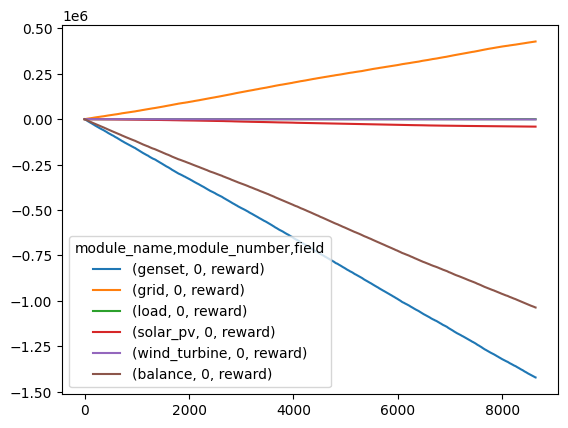

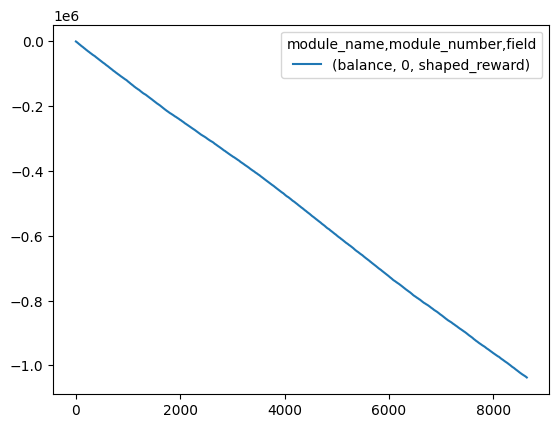

In [229]:
microgrid.log.loc[:, pd.IndexSlice[:, :, "reward"]].cumsum().plot()
microgrid.log.loc[:, pd.IndexSlice["balance", :, "shaped_reward"]].cumsum().plot()
plt.show()

## Random exploration prob; 100 times

In [ ]:
for _ in range(100):
    exploration_proba = np.random.uniform(0,1)
    microgrid.reset()
    for e in range(n_episodes): 
        done = False
        if np.random.uniform(0,1) < exploration_proba:
            action_id = np.random.choice(len(action_list))
            action = action_list[action_id]
        else:
            action_id = np.argmax(q_table[e])
            action = action_list[action_id]
            
        observation, reward, done, info = microgrid.run(action)
    
        if done:
            print(f"Breaking at ep: {e}; Reward: {microgrid.log.loc[:, pd.IndexSlice['balance', :, 'shaped_reward']].sum().iloc[0]}; Exploration Probability: {exploration_proba}")
            max_future_q = 0.0
            current_q = q_table[e, action_id]
            new_q = (1 - lr) * current_q + lr * (reward + gamma * max_future_q)
            q_table[e, action_id] = new_q
            break
        
    
        max_future_q = np.max(q_table[e+1])
        current_q = q_table[e, action_id]
        
        
        new_q = (1 - lr) * current_q + lr * (reward + gamma * max_future_q)
        q_table[e, action_id] = new_q
        #exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e))
    

## Single run-through; full exploitation

In [28]:
exploration_proba = 0
microgrid.reset()
for e in range(n_episodes): 
    done = False
    if np.random.uniform(0,1) < exploration_proba:
        action_id = np.random.choice(len(action_list))
        action = action_list[action_id]
    else:
        action_id = np.argmax(q_table[e])
        action = action_list[action_id]
        
    observation, reward, done, info = microgrid.run(action)

    if done:
        print(f"Breaking at ep: {e}; Reward: {microgrid.log.loc[:, pd.IndexSlice['balance', :, 'shaped_reward']].sum().iloc[0]}; Exploration Probability: {exploration_proba}")
        max_future_q = 0.0
        current_q = q_table[e, action_id]
        new_q = (1 - lr) * current_q + lr * (reward + gamma * max_future_q)
        q_table[e, action_id] = new_q
        break
    

    max_future_q = np.max(q_table[e+1])
    current_q = q_table[e, action_id]
    
    
    new_q = (1 - lr) * current_q + lr * (reward + gamma * max_future_q)
    q_table[e, action_id] = new_q

Breaking at ep: 8639; Reward: -49012.0902677843; Exploration Probability: 0


## Full exploit; 100 runs

In [14]:
for sim in range(353):
    exploration_proba = 0
    microgrid.reset()
    for e in range(n_episodes): 
        done = False
        if np.random.uniform(0,1) < exploration_proba:
            action_id = np.random.choice(len(action_list))
            action = action_list[action_id]
        else:
            action_id = np.argmax(q_table[e])
            action = action_list[action_id]
            
        observation, reward, done, info = microgrid.run(action)
    
        if done:
            print(f"Simulation {sim}; Breaking at ep: {e}; Reward: {microgrid.log.loc[:, pd.IndexSlice['balance', :, 'shaped_reward']].sum().iloc[0]}; Exploration Probability: {exploration_proba}")
            max_future_q = 0.0
            current_q = q_table[e, action_id]
            new_q = (1 - lr) * current_q + lr * (reward + gamma * max_future_q)
            q_table[e, action_id] = new_q
            break
        
    
        max_future_q = np.max(q_table[e+1])
        current_q = q_table[e, action_id]
        
        
        new_q = (1 - lr) * current_q + lr * (reward + gamma * max_future_q)
        q_table[e, action_id] = new_q
        #exploration_proba = max(min_exploration_proba, np.exp(-exploration_decreasing_decay*e))
    

Simulation 0; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 1; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 2; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 3; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 4; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 5; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 6; Breaking at ep: 8639; Reward: -94182.46587335918; Exploration Probability: 0
Simulation 7; Breaking at ep: 8639; Reward: -93723.06297671964; Exploration Probability: 0
Simulation 8; Breaking at ep: 8639; Reward: -90228.67026226102; Exploration Probability: 0
Simulation 9; Breaking at ep: 8639; Reward: -90228.5477617386; Exploration Probability: 0
Simulation 10; Breaking at ep: 8639; Reward: -93675.87840049938; Exploration Probability: 0

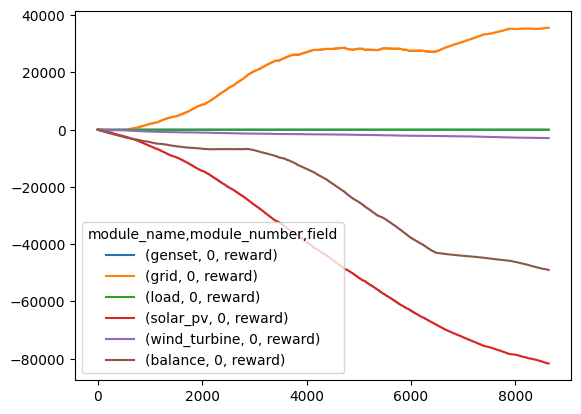

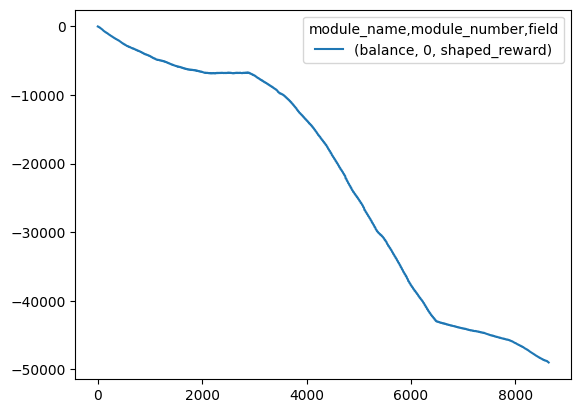

In [31]:
microgrid.log.loc[:, pd.IndexSlice[:, :, "reward"]].cumsum().plot()
microgrid.log.loc[:, pd.IndexSlice["balance", :, "shaped_reward"]].cumsum().plot()
plt.show()

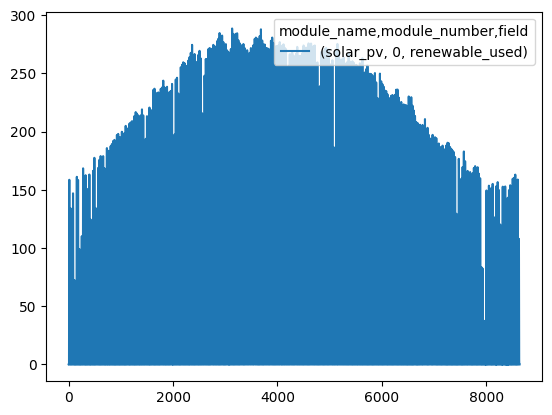

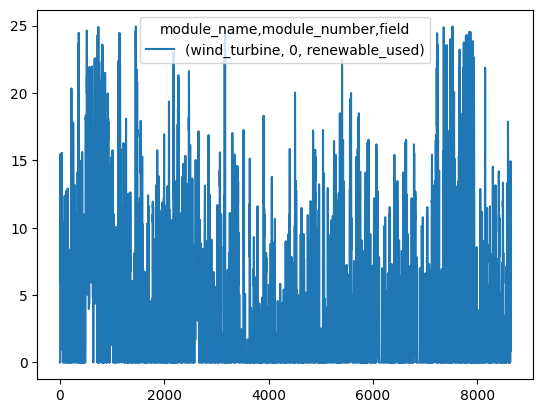

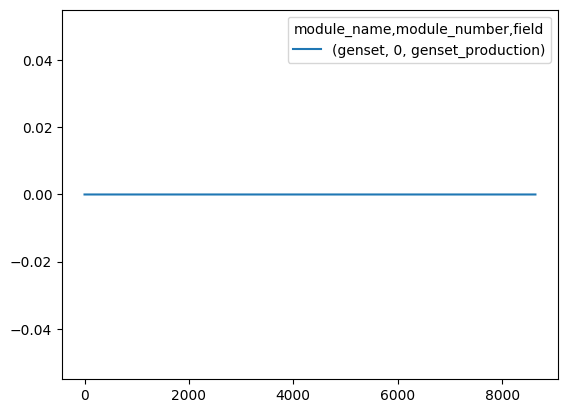

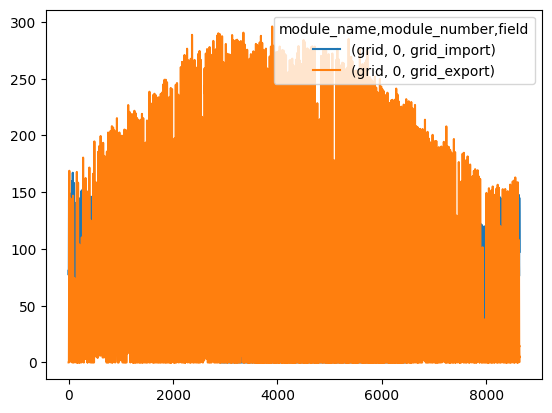

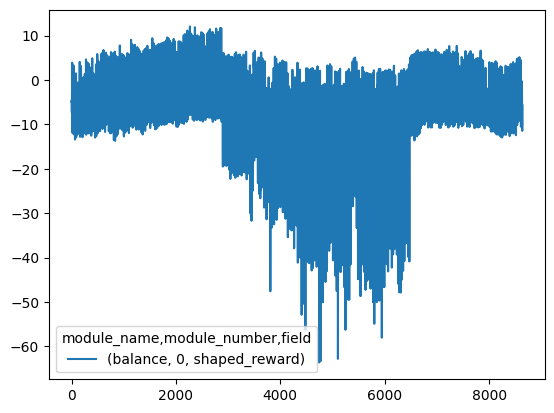

In [32]:
microgrid.log.loc[:, pd.IndexSlice["solar_pv", :, "renewable_used"]].plot()
microgrid.log.loc[:, pd.IndexSlice["wind_turbine", :, "renewable_used"]].plot()
microgrid.log.loc[:, pd.IndexSlice["genset", :, "genset_production"]].plot()
microgrid.log.loc[:, pd.IndexSlice["grid", :, ["grid_import", "grid_export"]]].plot()
microgrid.log.loc[:, pd.IndexSlice["balance", :, "shaped_reward"]].plot()
plt.show()

In [33]:
microgrid.log.to_csv("mediumRL.csv")

In [29]:
(q_table == 0).sum()

0

In [30]:
q_table.max()

12.063176917191043

In [21]:
q_table.shape[0] * q_table.shape[1]

3041280